In [1]:
!nvidia-smi

Fri Dec 22 18:49:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Installs

In [2]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb
!pip install huggingface_hub

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/19

# Imports and HuggingFace login

In [3]:
import torch
import time
from huggingface_hub import notebook_login
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from transformers import TrainingArguments
from trl import SFTTrainer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
notebook_login()

# Loading Dataset from huggingface

In [6]:
dataset_name = "jawerty/html_dataset"
data_initial = load_dataset(dataset_name)
data_initial

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['html', 'label'],
        num_rows: 43
    })
})

We divide the data into training set and testing set

In [7]:
# Extract features and labels from the original dataset
X = data_initial['train']['html']  # Features
y = data_initial['train']['label']  # Labels

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a new dataset for training
train_data = {
    'html': X_train,
    'label': y_train,
}

# Create a new dataset for testing
test_data = {
    'html': X_test,
    'label': y_test,
}

# Convert the lists to a dictionary
train_data_dict = {'html': train_data['html'], 'label': train_data['label']}
test_data_dict = {'html': test_data['html'], 'label': test_data['label']}

# Create DatasetDict with Dataset
data = DatasetDict({
    'train': Dataset.from_dict(train_data_dict),
    'test': Dataset.from_dict(test_data_dict),
})

data

DatasetDict({
    train: Dataset({
        features: ['html', 'label'],
        num_rows: 34
    })
    test: Dataset({
        features: ['html', 'label'],
        num_rows: 9
    })
})

Train Data:
{'html': ['<div class="main-wrapper" role="main">\n    <div class="main-content">\n        <h1 class="zone-name-title h1">\n            \n            www.doordash.com\n        </h1>\n        <h2 class="h2" id="challenge-running">Checking if the site connection is secure</h2><div id="challenge-stage" style="display: none;"></div><div id="challenge-spinner" class="spacer loading-spinner" style="display: block; visibility: visible;"><div class="lds-ring"><div></div><div></div><div></div><div></div></div></div>\n        <noscript>\n            <div id="challenge-error-title">\n                <div class="h2">\n                    <span class="icon-wrapper">\n                        <div class="heading-icon warning-icon"></div>\n                    </span>\n                    <span id="challenge-error-text">\n                        Enable JavaScript and cookies to continue\n                    </span>\n                </div>\n            </div>\n        </noscript>\n        <d
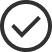

In [8]:
train_subset = data['train'][:5]  # Print the first 5 examples in the training set
test_subset = data['test'][:5]    # Print the first 5 examples in the test set

print("Train Data:")
print(train_subset)

print("\nTest Data:")
print(test_subset)

{'html': '<div class="main-wrapper" role="main">\n    <div class="main-content">\n        <h1 class="zone-name-title h1">\n            \n            www.doordash.com\n        </h1>\n        <h2 class="h2" id="challenge-running">Checking if the site connection is secure</h2><div id="challenge-stage" style="display: none;"></div><div id="challenge-spinner" class="spacer loading-spinner" style="display: block; visibility: visible;"><div class="lds-ring"><div></div><div></div><div></div><div></div></div></div>\n        <noscript>\n            <div id="challenge-error-title">\n                <div class="h2">\n                    <span class="icon-wrapper">\n                        <div class="heading-icon warning-icon"></div>\n                    </span>\n                    <span id="challenge-error-text">\n                        Enable JavaScript and cookies to continue\n                    </span>\n                </div>\n            </div>\n        </noscript>\n        <div id="trk_js
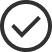

In [9]:
print(data["train"][0])
print(data["test"][0])

# Loading model and setting up configuration

Using sharded version of falcon-7b-instruct to run in free version of colab notebook.

In [10]:
model_name = "vilsonrodrigues/falcon-7b-instruct-sharded" # using sharded version of falcon-7b-instruct (gpu limitation on free colab notebook)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
model.config.use_cache = False

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/6.70k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vilsonrodrigues/falcon-7b-instruct-sharded:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vilsonrodrigues/falcon-7b-instruct-sharded:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/828M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [13]:
model.gradient_checkpointing_enable()

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [14]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 32 #16
lora_dropout = 0.05 #0.1
lora_rank = 32 #64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


trainable params: 65273856 || all params: 3674018688 || trainable%: 1.776633750209166


In [15]:
#Inference before training
prompt = f"""
Output only the HTML code for the give prompt.
<prompt>: Simple landing page.
<html_code>:
""".strip()
print(prompt)

Output only the HTML code for the give prompt.
<prompt>: Simple landing page.
<html_code>:


In [16]:
generation_config = model.generation_config
generation_config.max_new_tokens = 256
generation_config.temperature = 1
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [17]:
generation_config

GenerationConfig {
  "bos_token_id": 11,
  "eos_token_id": 11,
  "max_new_tokens": 256,
  "pad_token_id": 11,
  "top_p": 0.7
}

In [18]:
%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model.generate(
      input_ids=encoding.input_ids,
      attention_mask=encoding.attention_mask,
      generation_config=generation_config,
  )
print(tokenizer.decode(outputs[0],skip_special_tokens=True))

Output only the HTML code for the give prompt.
<prompt>: Simple landing page.
<html_code>:
<html>
  <body>
    <h1>Welcome!</h1>
    <p>This is a simple landing page.</p>
  </body>
</html>
CPU times: user 6.65 s, sys: 96.9 ms, total: 6.74 s
Wall time: 7.75 s


In [19]:
def generate_prompt(data_point):
  return f"""
  Output only the HTML code for the give prompt.
  <prompt>: {data_point["label"]}
  <html_code>: {data_point["html"]}
  """.strip()
  # return f"""
  # <human>: {data_point["question"]}
  # <AI>: {data_point["answer"]}
  # """.strip()

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  print(full_prompt)
  tokenized_full_prompt = tokenizer(full_prompt,padding=True, truncation=True)
  return tokenized_full_prompt

{'html': '<div class="main-wrapper" role="main">\n    <div class="main-content">\n        <h1 class="zone-name-title h1">\n            \n            www.doordash.com\n        </h1>\n        <h2 class="h2" id="challenge-running">Checking if the site connection is secure</h2><div id="challenge-stage" style="display: none;"></div><div id="challenge-spinner" class="spacer loading-spinner" style="display: block; visibility: visible;"><div class="lds-ring"><div></div><div></div><div></div><div></div></div></div>\n        <noscript>\n            <div id="challenge-error-title">\n                <div class="h2">\n                    <span class="icon-wrapper">\n                        <div class="heading-icon warning-icon"></div>\n                    </span>\n                    <span id="challenge-error-text">\n                        Enable JavaScript and cookies to continue\n                    </span>\n                </div>\n            </div>\n        </noscript>\n        <div id="trk_js
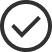

In [20]:
for data_point in data['train']:
  print(data_point)

In [21]:
%load_ext tensorboard
%tensorboard --logdir experiments/runs

<IPython.core.display.Javascript object>

# Load Trainer

In [22]:
output_dir = "falcon7binstruct_HtmlCodeGeneration"
per_device_train_batch_size = 16 #4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 10
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 60 #100 #500
warmup_ratio = 0.03
lr_scheduler_type = "cosine" #"constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    push_to_hub=True
)

['Output only the HTML code for the give prompt.\n  <prompt>: this is a colorful landing page with a search bar\n  <html_code>: <div class="main-wrapper" role="main">\n    <div class="main-content">\n        <h1 class="zone-name-title h1">\n            \n            www.doordash.com\n        </h1>\n        <h2 class="h2" id="challenge-running">Checking if the site connection is secure</h2><div id="challenge-stage" style="display: none;"></div><div id="challenge-spinner" class="spacer loading-spinner" style="display: block; visibility: visible;"><div class="lds-ring"><div></div><div></div><div></div><div></div></div></div>\n        <noscript>\n            <div id="challenge-error-title">\n                <div class="h2">\n                    <span class="icon-wrapper">\n                        <div class="heading-icon warning-icon"></div>\n                    </span>\n                    <span id="challenge-error-text">\n                        Enable JavaScript and cookies to continue\
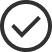

In [23]:
from datasets import Dataset, DatasetDict

list_of_strings = []
for data_point in data["train"]:
  list_of_strings.append(generate_prompt(data_point))

print(list_of_strings)
# Create a dictionary with the list of strings
data_dict = {'text': list_of_strings}

# Create a dataset from the dictionary
train_dataset = Dataset.from_dict(data_dict)

# Create a DatasetDict
final_data = DatasetDict({'train': train_dataset})

# Print the dataset
print(final_data)

# Training

In [24]:
max_seq_length = 256

trainer = SFTTrainer(
    model=model,
    train_dataset=final_data['train'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

In [25]:
model.config.use_cache = False
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=60, training_loss=0.3835207174221675, metrics={'train_runtime': 1438.2817, 'train_samples_per_second': 2.67, 'train_steps_per_second': 0.042, 'total_flos': 1.33455784651776e+16, 'train_loss': 0.3835207174221675, 'epoch': 40.0})

60 steps is enough. (Determined from training loss)

In [26]:
trainer.push_to_hub()

'https://huggingface.co/shyam1909/falcon7binstruct_HtmlCodeGeneration/tree/main/'

In [ ]:
# Loading PEFT model
PEFT_MODEL = "shyam1909/falcon7binstruct_HtmlCodeGeneration"
config = PeftConfig.from_pretrained(PEFT_MODEL)
peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

peft_model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)

peft_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

In [ ]:
# Save dataset
data.save_to_disk("./dataset")

# Saving the test and train dataset to be used in LLM evaluation in another notebook

In [ ]:
# Save dataset to local
import shutil

folder_path = '/content/dataset'
zip_path = '/content/dataset'

shutil.make_archive(zip_path, 'zip', folder_path)
from google.colab import files

files.download(zip_path)